In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import default_collate
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from torchmetrics import SpearmanCorrCoef
from scipy.interpolate import interp1d
import sys

sys.path.append('..')
from utils import Metrics

## Evaluation for M&M Dataset - Downstream Segmentation Performance

In [75]:
data = {
    'No Compression - Reconstruction': np.load('../../results-tmp/heart_downstream_results_localAug_multiImgSingleView_recon_balanced_same.npy', allow_pickle=True).item(),
    'U-Net': np.load('../../results-tmp/results/unet/heart_unet_results.npy', allow_pickle=True).item(),
    #'first_resDAE': np.load('../../results-tmp/heart_downstream_results_resDAE.npy', allow_pickle=True).item(),
    'No Compression - Residual': np.load('../../results-tmp/heart_downstream_results_localAug_multiImgSingleView_res_balanced_same.npy', allow_pickle=True).item(),
    'Ensemble': np.load('../../results-tmp/results/unet/heart_ensemble_results.npy', allow_pickle=True).item(),
}

In [76]:
df = pd.DataFrame(columns=['acdc_train', 'acdc_val', 'mnm_siemens', 'mnm_philips', 'mnm_ge', 'mnm_canon', 'method'])
for key in data:
    df_tmp = pd.DataFrame.from_dict(data[key])
    df_tmp['method'] = key
    
    df = pd.concat([df, df_tmp], ignore_index=True)
    
df = pd.melt(df, id_vars=['method'])
df = df.rename(columns={'variable': 'scanner', 'value': 'DSC'})

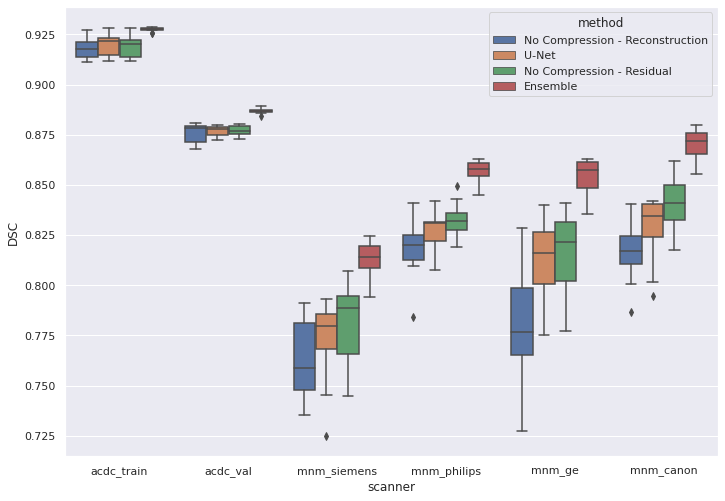

In [80]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
g = sns.boxplot(data=df, x='scanner', y='DSC', hue='method')
plt.savefig("../../results-tmp/results/eval/dsc_res-dae_meeting-07-09.jpg", bbox_inches='tight', dpi=400)

## Evaluation for M&M Dataset - Image Level Analysis

In [3]:
def get_image_data(method: str, net_out: str, task: str, scanner: int):
    directory = f'../../results-tmp/results/eval/{net_out}/image/'
    image_data = []
    for file in os.listdir(directory):
        #print(file, method, net_out, task, scanner)
        #print(f'-{scanner}-')
        if f'-{method}-' in file and f'-{task}-' in file and f'-{scanner}-' in file:
            f = torch.load(directory + file)
            #print(file, '!')
            if 'corr' in f.keys():
                f['corr'].target = [t.cpu() for t in f['corr'].target]
                f['corr'].preds = [t.cpu() for t in f['corr'].preds]
                f['corr'] = f['corr'].compute()
            image_data.append(f)
        #if 'testing' in file:    
        #    print(file)
    #print(image_data)
    return default_collate(image_data)

In [82]:
df_corr_mms = pd.DataFrame(columns=['method', 'Domain', 'run', r'Spearmans $\rho$'])
#for method in ['gonzales', 'latents', 'entropy', 'ensemble_tmp', 'ae', 'testing']:
#for method in ['ae', 'single_CE', 'single_CEMSE_1prior', 'multi_CE', 'multi_CEMSE_1prior', 'single_MSEMSE_1prior']:
#methods = ['ae', 'ensemble_tmp', 'single_CEMSE_1prior', 'local_aug', 'localAug_multiImgSingleView_res_balanced_channel', 'localAug_multiImgSingleView_recon_balanced_same']
#methods = ['ensemble_tmp', 'ae', 'localAug_multiImgSingleView_recon_balanced_same', 'localAug_multiImgSingleView_res_balanced_same']
methods = ['ae_acc', 'gonzales_acc', 'localAug_multiImgSingleView_res_balanced_same_acc']


for method in methods:
#for method in ['entropy', 'ensemble','ensemble_tmp', 'ae']:
 
    for scanner in ['val', 'A', 'B', 'C', 'D']:
    #for scanner in ['val', 'C', 'D']:
        
        
        try:
            tmp = get_image_data(method=method, 
                                 net_out='mms', 
                                 task='both', 
                                 scanner=str(scanner))
        except:
            tmp = get_image_data(method=method, 
                                 net_out='mms', 
                                 task='corr', 
                                 scanner=str(scanner))

        if scanner == 'A':
            domain = 'Siemens \n(M&M)'
        if scanner == 'B':
            domain = 'Philips'
        if scanner == 'C':
            domain = 'GE'
        if scanner == 'D':
            domain = 'Canon'
        if scanner == 'val':
            domain = 'Siemens \n(ACDC)'
            
            
        if method == 'gonzales' or method == 'gonzales_acc':
            m = 'Pooling Mahalanobis'
        if method == 'entropy':
            m = 'Entropy - Single Net'
        if method == 'latents':
            m = 'Latent Mahalanobis'
        if method == 'ae' or method == 'ae_acc':
            m = 'Segmentation Distortion'
        if method == 'ensemble_tmp':
            m = 'Entropy - Ensemble'
        if method == 'single_CE':
            m = 'Single res DAE - CE only'
        if method == 'multi_CE':
            m = 'Multiple res DAEs - CE only'
        if method == 'multi_CEMSE_1prior':
            m = 'Multiple res DAEs - CE and MSE'
        if method == 'single_CEMSE_1prior':
            m = 'Single res DAEs - CE and MSE'
        if method == 'single_MSEMSE_1prior':
            m = 'Single res DAEs - MSE and MSE'
        if method == 'true_denoising':
            m = 'Augmentation Denoising Baseline'
        if method == 'local_aug':
            m = 'Local Augmentation Denoising'
        if method == 'localAug_multiImgSingleView_res_balanced_channel':
            m = 'Channel Compression - Residual'
        if method == 'localAug_multiImgSingleView_res_balanced_same' or method == 'localAug_multiImgSingleView_res_balanced_same_acc':
            m = 'No Compression - Residual'
        if method == 'localAug_multiImgSingleView_recon_balanced_same':
            m = 'No Compression - Reconstruction'
        
        for i, corr in enumerate(tmp['corr']):

            row = {'Domain': domain,
                   'method': m,
                   'run': i,
                   r'Spearmans $\rho$': corr.numpy().item()}

            df_corr_mms = df_corr_mms.append(row, ignore_index=True)

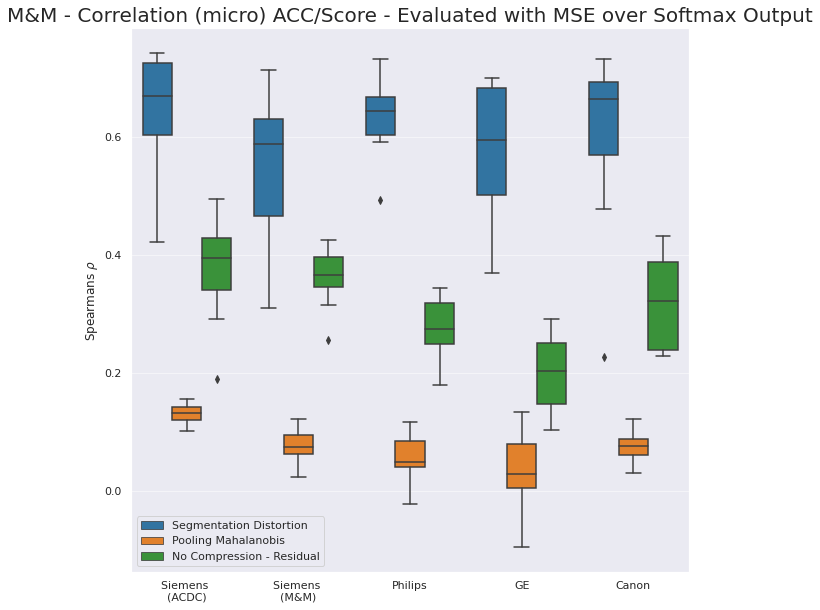

In [86]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
colors = sns.color_palette('tab10', len(methods))
palette = {method: color for method, color in zip(df_corr_mms['method'].unique(), colors)}
sns.boxplot(ax = axes, x="Domain", y=r'Spearmans $\rho$',
            hue="method", data=df_corr_mms, palette=palette)
#axes[0].get_legend().remove()
axes.legend().set_title('')
axes.set_title('M&M - Correlation (micro) ACC/Score - Evaluated with MSE over Softmax Output', fontsize=20)
axes.set_xlabel("")
axes.set_axisbelow(True) 
axes.yaxis.grid(True, alpha=0.5, zorder=0)
fig.savefig("../../results-tmp/results/eval/err_corr_accuracy-test.jpg", bbox_inches='tight', dpi=400)

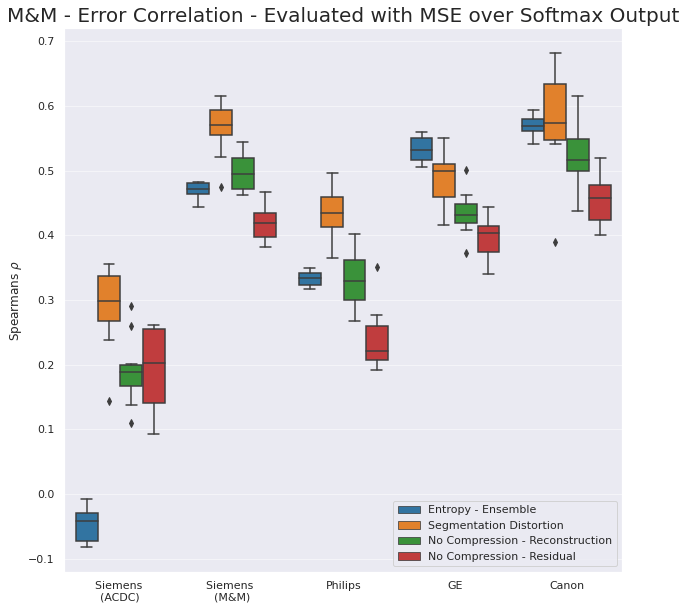

In [72]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
colors = sns.color_palette('tab10', len(methods))
palette = {method: color for method, color in zip(df_corr_mms['method'].unique(), colors)}
sns.boxplot(ax = axes, x="Domain", y=r'Spearmans $\rho$',
            hue="method", data=df_corr_mms, palette=palette)
#axes[0].get_legend().remove()
axes.legend().set_title('')
axes.set_title('M&M - Error Correlation - Evaluated with MSE over Softmax Output', fontsize=20)
axes.set_xlabel("")
axes.set_axisbelow(True) 
axes.yaxis.grid(True, alpha=0.5, zorder=0)
fig.savefig("../../results-tmp/results/eval/err_corr_res-dae_meeting-07-09.jpg", bbox_inches='tight', dpi=400)

In [51]:
directory = f'../../results-tmp/results/eval/mms/image/'

for scanner in scanners:
    acdc_AugResDAE0_localAug_multiImgSingleView_recon_balanced_same
    file = f'mms-local_aug-both-{scanner}-0'
    f = torch.load(directory + file)
    print(f['corr'].compute())

tensor(0.3419)
tensor(0.3727)
tensor(0.2650)
tensor(0.4747)
tensor(0.4687)


In [6]:
directory = f'../../results-tmp/results/eval/mms/image/'

for scanner in scanners:
    file = f'mms-localAug_multiImgSingleView_recon_balanced_same-corr-{scanner}-0'
    f = torch.load(directory + file)
    print(f['corr'].compute())

tensor(0.2454)
tensor(0.5489)
tensor(0.3358)
tensor(0.4563)
tensor(0.5487)


In [128]:
directory = f'../../results-tmp/results/eval/mms/image/'

for scanner in scanners:

    file = f'mms-multi_CEMSE_4prior-both-{scanner}-0'
    f = torch.load(directory + file)
    print(f['corr'].compute())

tensor(0.0868)
tensor(0.3563)
tensor(0.2800)
tensor(0.4323)
tensor(0.4517)


## Pixel - Level Analysis

In [11]:
direc = '../../results-tmp/results/eval/mms/pixel/mms-res_dae-D-0-venus'
data = torch.load(direc)

{'A - Segmentation Distortion', 'D - No Compression - Residual', 'B - Entropy - Ensemble', 'C - No Compression - Reconstruction'}


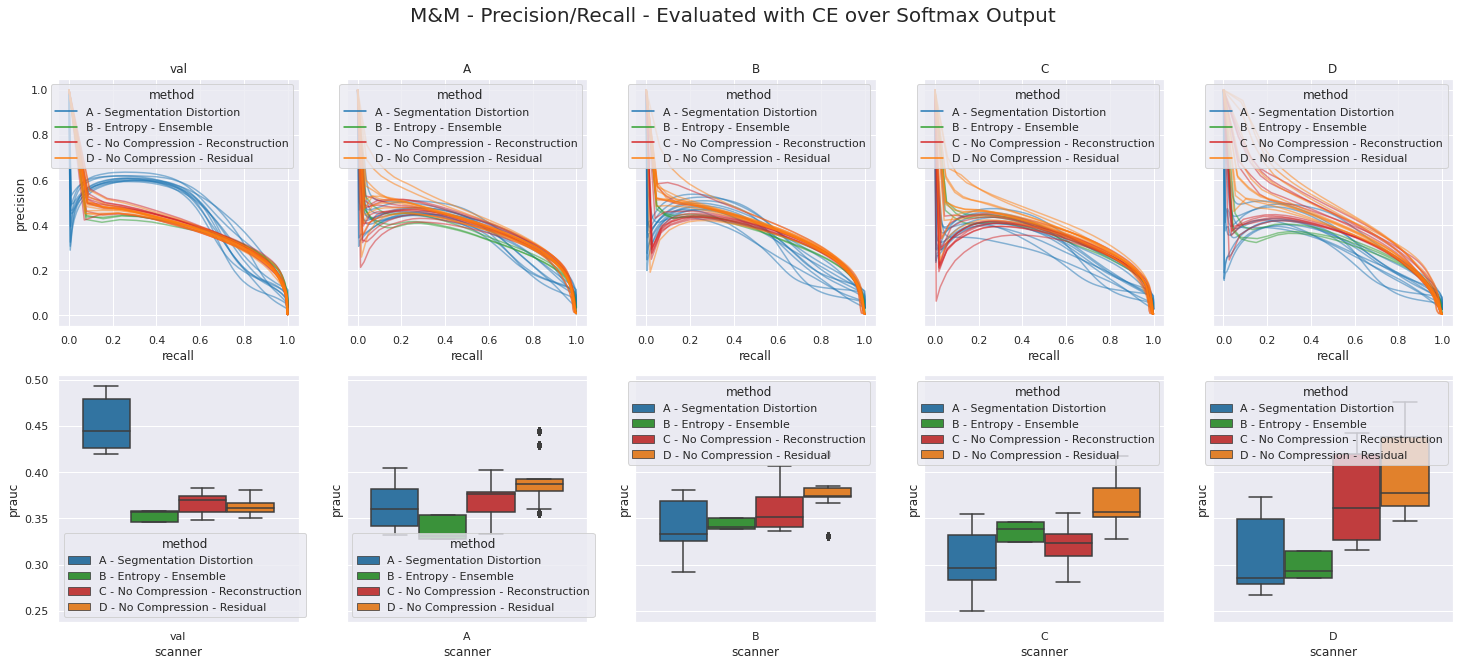

In [81]:

# external params
#'multi_CEMSE_1prior','multi_CEMSE_4prior', 
# ['multi_CEMSE_1prior', 'multi_CEMSE', 'multi_CE', 'single_CE', 'ensemble']
# methods = ['true_denoising', 'multi_CEMSE_1prior', 'single_CEMSE_1prior', 'ensemble', 'ae']
#methods = ['localAug_multiImgSingleView_res_balanced_channel', 'local_aug', 'true_denoising', 'single_CEMSE_1prior', 'ensemble']
#methods = ['localAug_multiImgSingleView_res_balanced_same', 'localAug_multiImgSingleView_res_balanced_channel', 'ensemble', 'ae']
#methods = ['localAug_multiImgSingleView_recon_balanced_same', 'localAug_multiImgSingleView_res_balanced_same', 'localAug_multiImgSingleView_res_balanced_channel', 'ensemble', 'ae']
methods = ['ae', 'ensemble', 'localAug_multiImgSingleView_recon_balanced_same', 'localAug_multiImgSingleView_res_balanced_same']

#methods = ['local_aug', 'ensemble']

scanners = ['val', 'A', 'B', 'C', 'D']
#scanners = ['val', 'C']
# internal params
directory = f'../../results-tmp/results/eval/mms/pixel/'

# future function content

df = pd.DataFrame(columns=['precision', 'recall', 'scanner', 'run', 'method'])
Methods = []
for file in os.listdir(directory):
    for method in methods:
        
        for scanner in scanners:
            if f'mms-{method}-{scanner}' in file:
                #print(file)
                run = int(file[-1])
#                 if run != 0:
#                     continue
                
                data = torch.load(directory + file)
                data.pre[-1] = 1
                if method == 'gonzales':
                    m = 'Pooling Mahalanobis'
                if method == 'entropy':
                    m = 'Entropy - Single Net'
                if method == 'latents':
                    m = 'Latent Mahalanobis'
                if method == 'ae':
                    m = 'A - Segmentation Distortion'
                if method == 'ensemble':
                    m = 'B - Entropy - Ensemble'
                if method == 'single_CE':
                    m = 'Single res DAE - CE only'
                if method == 'multi_CE':
                    m = 'Multiple res DAEs - CE only'
                if method == 'multi_CEMSE_1prior':
                    m = 'Multiple res DAEs - CE and MSE'
                if method == 'single_CEMSE_1prior':
                    m = 'Single res DAEs - CE and MSE'
                if method == 'single_MSEMSE_1prior':
                    m = 'Single res DAEs - MSE and MSE'
                if method == 'true_denoising':
                    m = 'Augmentation Denoising Baseline'
                if method == 'local_aug':
                    m = 'Local Augmentation Denoising'
                if method == 'localAug_multiImgSingleView_res_balanced_channel':
                    m = 'Channel Compression - Residual'
                if method == 'localAug_multiImgSingleView_res_balanced_same':
                    m = 'D - No Compression - Residual'
                if method == 'localAug_multiImgSingleView_recon_balanced_same':
                    m = 'C - No Compression - Reconstruction'
                
                
                Methods.append(m)
                    
                data_df = pd.DataFrame()
                data_df['precision'] = data.pre
                data_df['recall']    = data.rec
                data_df['method']    = m
                data_df['scanner']   = scanner
                data_df['run']       = run
                data_df['prauc']     = data.auc_pr
                df = df.append(data_df, ignore_index=True)
        #print(data_df)
        #break
        
df = df.sort_values('method')

Methods = set(Methods)
print(Methods)
fig, axes = plt.subplots(2, 5, figsize=(25, 10), sharey='row')
colors = sns.color_palette('tab10', len(methods))
palette = {method: color for method, color in zip(Methods, colors)}

for i, scanner in enumerate(scanners):
    sns.lineplot(
        ax=axes[0, i],
        data=df[(df['scanner'] == scanner)], 
        x='recall', 
        y='precision', 
        hue='method', 
        units='run',
        palette=palette,
        alpha=0.5, 
        estimator=None
    )
    axes[0, i].set_title(scanner)
    
    sns.boxplot(
        ax=axes[1, i],
        data=df[(df['scanner'] == scanner)],
        x="scanner", 
        y='prauc',
        hue="method",
        palette=palette,
    )
    

fig.suptitle('M&M - Precision/Recall - Evaluated with CE over Softmax Output', fontsize=20)
fig.savefig("../../results-tmp/results/eval/pr_res-dae_meeting-07-09.jpg", bbox_inches='tight', dpi=400, transparent=False)

Text(0.5, 0.98, 'M&M - Precision/Recall - Evaluated with CE over Softmax Output')

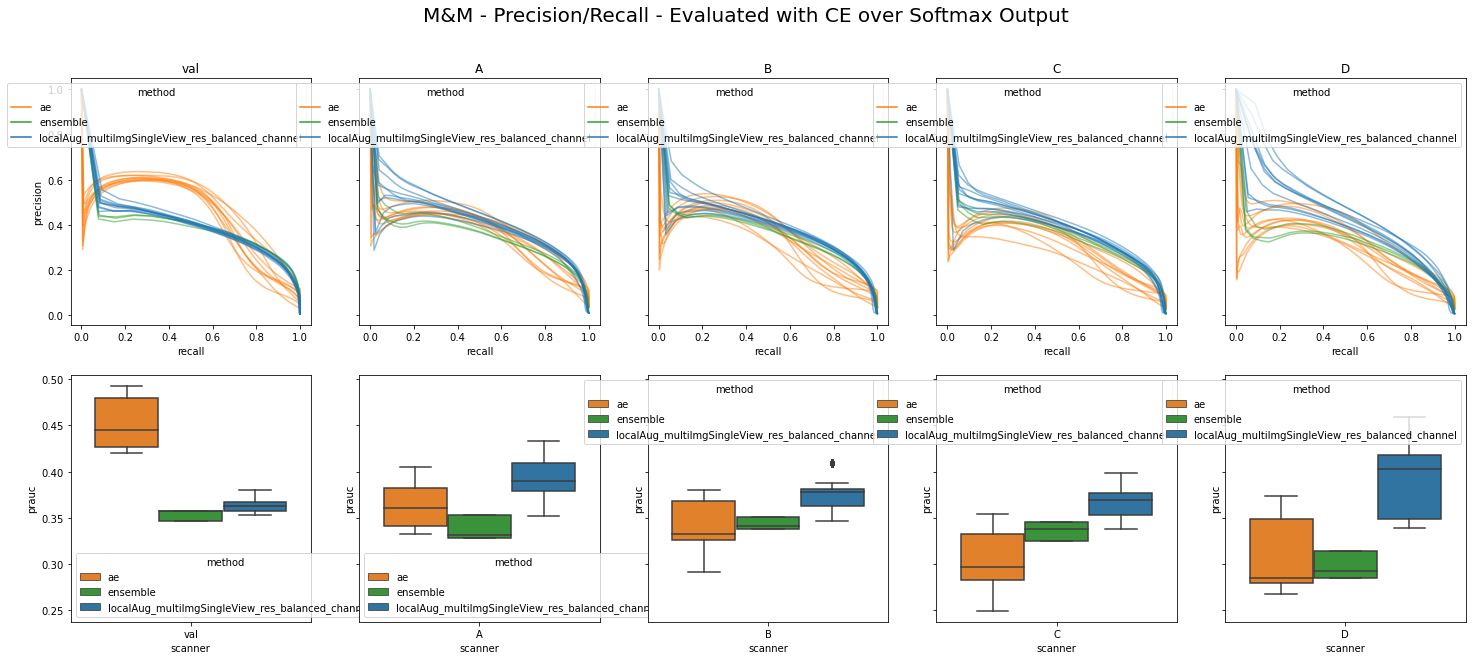

In [103]:

# external params
#'multi_CEMSE_1prior','multi_CEMSE_4prior', 
# ['multi_CEMSE_1prior', 'multi_CEMSE', 'multi_CE', 'single_CE', 'ensemble']
# methods = ['true_denoising', 'multi_CEMSE_1prior', 'single_CEMSE_1prior', 'ensemble', 'ae']
methods = ['localAug_multiImgSingleView_res_balanced_channel', 'ae', 'ensemble']
#methods = ['local_aug', 'ensemble']

scanners = ['val', 'A', 'B', 'C', 'D']

# internal params
directory = f'../../results-tmp/results/eval/mms/pixel/'

# future function content

df = pd.DataFrame(columns=['precision', 'recall', 'scanner', 'run', 'method'])

for file in os.listdir(directory):
    for method in methods:
        for scanner in scanners:
            if f'mms-{method}-{scanner}' in file:
                #print(file)
                run = int(file[-1])
#                 if run != 0:
#                     continue
                
                data = torch.load(directory + file)
                data.pre[-1] = 1
                #x = np.linspace(0, 1, len(data.pre))
                #print(x)
                #F = interp1d(x, data.rec, fill_value='extrapolate')
                #y = F(data.rec)
                data_df = pd.DataFrame()
                data_df['precision'] = data.pre
                data_df['recall']    = data.rec
                data_df['method']    = method
                data_df['scanner']   = scanner
                data_df['run']       = run
                data_df['prauc']     = data.auc_pr
                df = df.append(data_df, ignore_index=True)
        #print(data_df)
        #break
        
df = df.sort_values('method')
        
fig, axes = plt.subplots(2, 5, figsize=(25, 10), sharey='row')
colors = sns.color_palette('tab10', len(methods))
palette = {method: color for method, color in zip(methods, colors)}

for i, scanner in enumerate(scanners):
    sns.lineplot(
        ax=axes[0, i],
        data=df[(df['scanner'] == scanner)], 
        x='recall', 
        y='precision', 
        hue='method', 
        units='run',
        palette=palette,
        alpha=0.5, 
        estimator=None
    )
    axes[0, i].set_title(scanner)
    
    sns.boxplot(
        ax=axes[1, i],
        data=df[(df['scanner'] == scanner)],
        x="scanner", 
        y='prauc',
        hue="method",
        palette=palette,
    )
    
    #axis[1, i].
    
#axes[0].set_title('M&M - Precision/Recall - Evaluated with CE over Softmax Output')
#plt.gca().set_title('title')
fig.suptitle('M&M - Precision/Recall - Evaluated with CE over Softmax Output', fontsize=20)
#fig.savefig("../../results-tmp/results/eval/pr_res-dae_meeting258.jpg", bbox_inches='tight', dpi=400, transparent=True)

Text(0.5, 0.98, 'M&M - Precision/Recall - Evaluated with CE over Softmax Output')

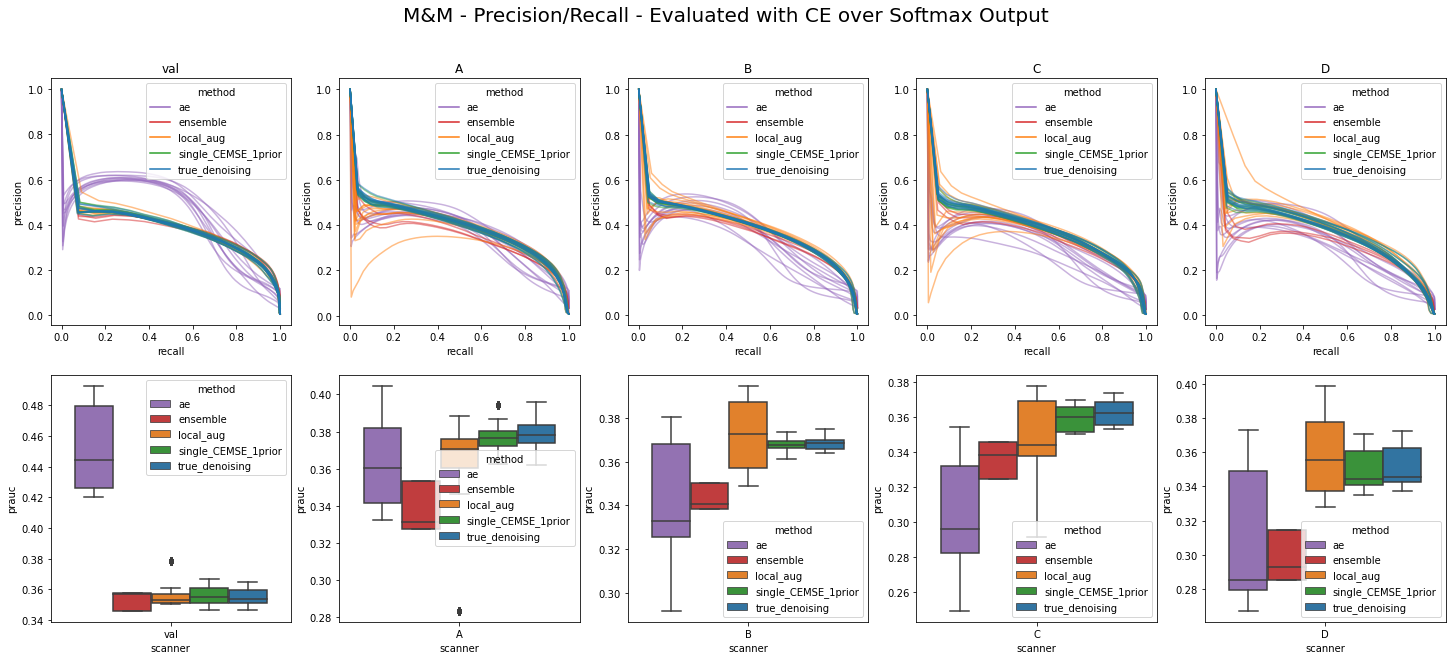

In [99]:
# external params
#'multi_CEMSE_1prior','multi_CEMSE_4prior', 
# ['multi_CEMSE_1prior', 'multi_CEMSE', 'multi_CE', 'single_CE', 'ensemble']
# methods = ['true_denoising', 'multi_CEMSE_1prior', 'single_CEMSE_1prior', 'ensemble', 'ae']
methods  = ['true_denoising', 'local_aug', 'single_CEMSE_1prior', 'ensemble', 'ae']
scanners = ['val', 'A', 'B', 'C', 'D']

# internal params
directory = f'../../results-tmp/results/eval/mms/pixel/'

# future function content

df = pd.DataFrame(columns=['precision', 'recall', 'scanner', 'run', 'method'])

for file in os.listdir(directory):
    for method in methods:
        for scanner in scanners:
            if f'mms-{method}-{scanner}' in file:
                #print(file)
                run = int(file[-1])
                data = torch.load(directory + file)
                data.pre[-1] = 1
                #x = np.linspace(0, 1, len(data.pre))
                #print(x)
                #F = interp1d(x, data.rec, fill_value='extrapolate')
                #y = F(data.rec)
                data_df = pd.DataFrame()
                data_df['precision'] = data.pre
                data_df['recall']    = data.rec
                data_df['method']    = method
                data_df['scanner']   = scanner
                data_df['run']       = run
                data_df['prauc']     = data.auc_pr
                df = df.append(data_df, ignore_index=True)
        #print(data_df)
        #break
        
df = df.sort_values('method')
        
fig, axes = plt.subplots(2, 5, figsize=(25, 10), sharey=False)
colors = sns.color_palette('tab10', len(methods))
palette = {method: color for method, color in zip(methods, colors)}

for i, scanner in enumerate(scanners):
    sns.lineplot(
        ax=axes[0, i],
        data=df[(df['scanner'] == scanner)], 
        x='recall', 
        y='precision', 
        hue='method', 
        units='run',
        palette=palette,
        alpha=0.5, 
        estimator=None
    )
    axes[0, i].set_title(scanner)
    
    sns.boxplot(
        ax=axes[1, i],
        data=df[(df['scanner'] == scanner)],
        x="scanner", 
        y='prauc',
        hue="method",
        palette=palette,
    )
    
    #axis[1, i].
    
#axes[0].set_title('M&M - Precision/Recall - Evaluated with CE over Softmax Output')
#plt.gca().set_title('title')
fig.suptitle('M&M - Precision/Recall - Evaluated with CE over Softmax Output', fontsize=20)
#fig.savefig("../../results-tmp/results/eval/pr_res-dae_meeting.jpg", bbox_inches='tight', dpi=400, transparent=True)

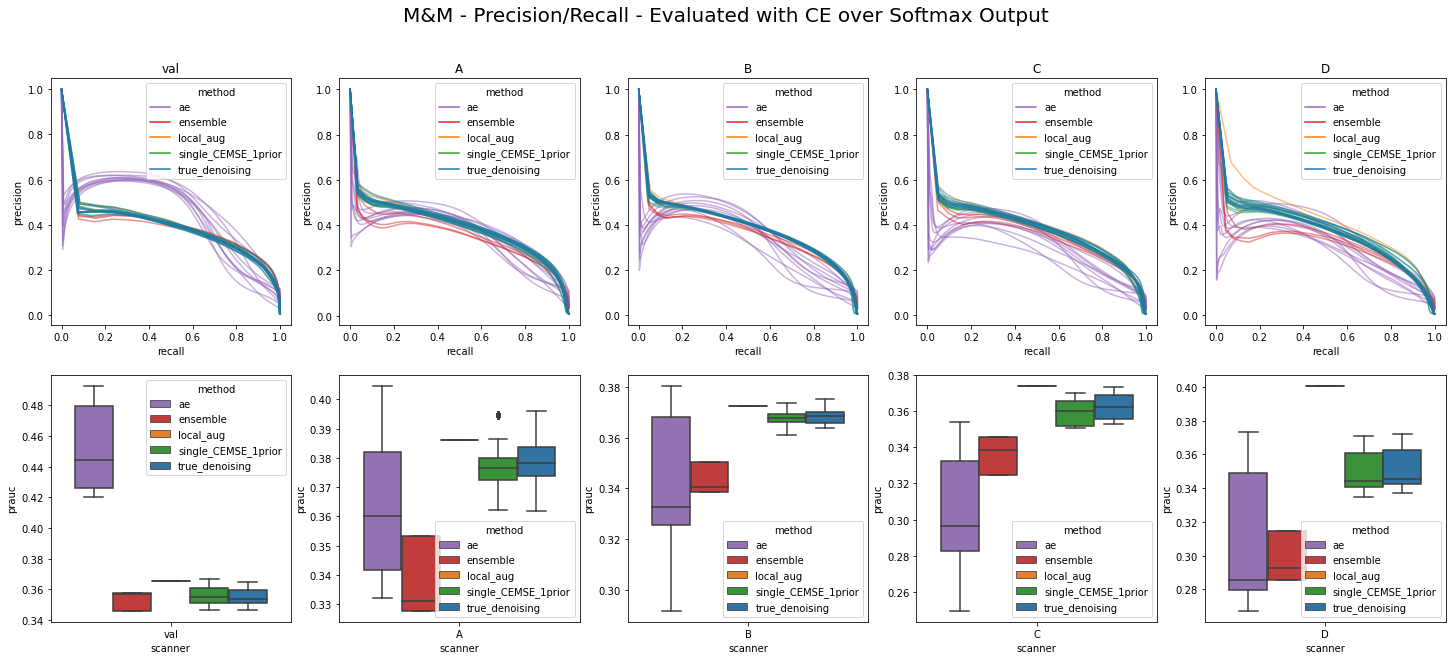

In [48]:
# external params
#'multi_CEMSE_1prior','multi_CEMSE_4prior', 
# ['multi_CEMSE_1prior', 'multi_CEMSE', 'multi_CE', 'single_CE', 'ensemble']
# methods = ['true_denoising', 'multi_CEMSE_1prior', 'single_CEMSE_1prior', 'ensemble', 'ae']
methods = ['true_denoising', 'local_aug', 'single_CEMSE_1prior', 'ensemble', 'ae']
scanners = ['val', 'A', 'B', 'C', 'D']

# internal params
directory = f'../../results-tmp/results/eval/mms/pixel/'

# future function content

df = pd.DataFrame(columns=['precision', 'recall', 'scanner', 'run', 'method'])

for file in os.listdir(directory):
    for method in methods:
        for scanner in scanners:
            if f'mms-{method}-{scanner}' in file:
                #print(file)
                run = int(file[-1])
                data = torch.load(directory + file)
                data.pre[-1] = 1
                #x = np.linspace(0, 1, len(data.pre))
                #print(x)
                #F = interp1d(x, data.rec, fill_value='extrapolate')
                #y = F(data.rec)
                data_df = pd.DataFrame()
                data_df['precision'] = data.pre
                data_df['recall']    = data.rec
                data_df['method']    = method
                data_df['scanner']   = scanner
                data_df['run']       = run
                data_df['prauc']     = data.auc_pr
                df = df.append(data_df, ignore_index=True)
        #print(data_df)
        #break
        
df = df.sort_values('method')
        
fig, axes = plt.subplots(2, 5, figsize=(25, 10), sharey=False)
colors = sns.color_palette('tab10', len(methods))
palette = {method: color for method, color in zip(methods, colors)}

for i, scanner in enumerate(scanners):
    sns.lineplot(
        ax=axes[0, i],
        data=df[(df['scanner'] == scanner)], 
        x='recall', 
        y='precision', 
        hue='method', 
        units='run',
        palette=palette,
        alpha=0.5, 
        estimator=None
    )
    axes[0, i].set_title(scanner)
    
    sns.boxplot(
        ax=axes[1, i],
        data=df[(df['scanner'] == scanner)],
        x="scanner", 
        y='prauc',
        hue="method",
        palette=palette,
    )
    
    #axis[1, i].
    
#axes[0].set_title('M&M - Precision/Recall - Evaluated with CE over Softmax Output')
#plt.gca().set_title('title')
fig.suptitle('M&M - Precision/Recall - Evaluated with CE over Softmax Output', fontsize=20)
fig.savefig("../../results-tmp/results/eval/pr_res-dae_meeting.jpg", bbox_inches='tight', dpi=400, transparent=True)

In [147]:
directory = f'../../results-tmp/results/eval/mms/pixel/'
file = 'mms-ensemble-val-0'
tmp = torch.load(directory + file)

In [148]:
tmp.pre

tensor([0.0149, 0.0300, 0.0330, 0.0352, 0.0370, 0.0387, 0.0401, 0.0415, 0.0428,
        0.0440, 0.0451, 0.0463, 0.0474, 0.0484, 0.0494, 0.0504, 0.0514, 0.0524,
        0.0534, 0.0543, 0.0553, 0.0562, 0.0571, 0.0580, 0.0589, 0.0598, 0.0607,
        0.0616, 0.0625, 0.0634, 0.0643, 0.0652, 0.0660, 0.0669, 0.0678, 0.0687,
        0.0696, 0.0705, 0.0713, 0.0722, 0.0731, 0.0740, 0.0749, 0.0758, 0.0767,
        0.0776, 0.0785, 0.0794, 0.0803, 0.0812, 0.0822, 0.0831, 0.0840, 0.0850,
        0.0859, 0.0868, 0.0878, 0.0888, 0.0897, 0.0907, 0.0917, 0.0927, 0.0936,
        0.0946, 0.0957, 0.0967, 0.0977, 0.0987, 0.0997, 0.1008, 0.1018, 0.1029,
        0.1040, 0.1051, 0.1062, 0.1073, 0.1084, 0.1095, 0.1106, 0.1118, 0.1129,
        0.1141, 0.1152, 0.1164, 0.1176, 0.1188, 0.1201, 0.1213, 0.1225, 0.1238,
        0.1251, 0.1264, 0.1277, 0.1290, 0.1303, 0.1316, 0.1330, 0.1344, 0.1358,
        0.1372, 0.1386, 0.1401, 0.1415, 0.1430, 0.1445, 0.1460, 0.1475, 0.1491,
        0.1507, 0.1523, 0.1539, 0.1555, 

In [47]:
directory = f'../../results-tmp/results/eval/mms/pixel/'

for scanner in scanners:
    file = f'mms-local_aug-{scanner}-0'
    f = torch.load(directory + file)
    print(f.auc_pr)

0.3654882609844208
0.38620492815971375
0.3725183308124542
0.3739880621433258
0.40071961283683777
